# Volcanic Outlier Detection

In [27]:
from temp_clustering import cluster_temp_diff
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from scipy import signal, ndimage

In [7]:
ds_solar = xr.open_dataset('../data/Solar_forcing_1st_mill.nc')
ds_volc = xr.open_dataset('../data/Volc_Forc_AOD_1st_mill.nc')
ds_temp_r1 = xr.open_dataset('../data/T2m_R1_ym_1stMill.nc')
ds_temp_r2 = xr.open_dataset('../data/T2m_R2_ym_1stMill.nc')

In [8]:
n_clusters = 10
clusters_rel = cluster_temp_diff(ds_temp_r1, n_clusters)

In [4]:
def smooth_butter(data):
    # Butterworth filter settings
    cutoff = 0.125   # Hz
    order = 8
    [b, a] = signal.butter(order, cutoff)   # The second parameter is a normed value in [0;1] where 1 is the Nyquist frequency, i.e. half of the sampling rate. In the case of 25 FPS, this means that 1 = 12.5 Hz and hence 0.08 = 1 Hz

    # axis = 0 means that the filter is applied on each column
    data = signal.filtfilt(b, a, data, method='gust')

    return data

## Outlier detection based on clusters

In [39]:
selected_cluster = [6, 7]
cluster_temps = [ds_temp_r1['T2m'].values[:, clusters_rel == c] for c in selected_cluster]
cluster_temps = np.concatenate([cluster_temps[0], cluster_temps[1]], axis=1)

cluster_temps_diffs = np.zeros(cluster_temps.shape)
for i in range(cluster_temps.shape[1]):
    cluster_temps_diffs[:, i] = ndimage.convolve(cluster_temps[:, i], [-1, 0, 1], mode='reflect')

X = cluster_temps.copy()
X = StandardScaler().fit_transform(X)

clf = IsolationForest(random_state=0, contamination=0.03).fit(X)
outlier = clf.predict(X)

aod = ds_volc.AOD.values.flatten()

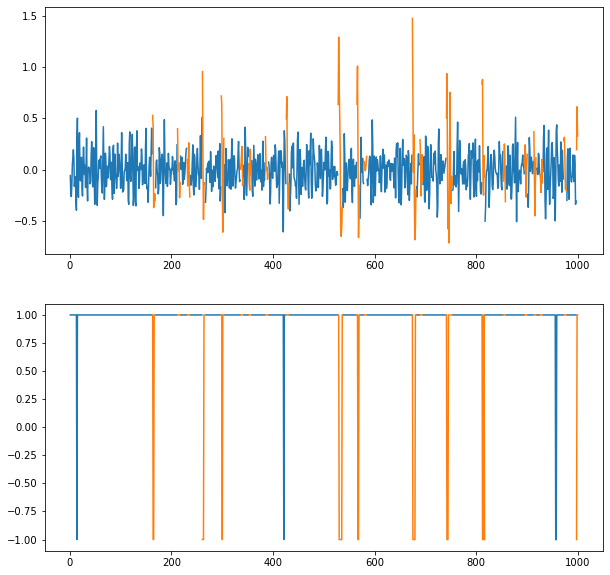

In [40]:
def plot_outlier(ax, data):
    time = np.arange(999) + 1
    c1_in = np.ma.masked_array(data, aod > 0)
    c1_out = np.ma.masked_array(data, aod <= 0)
    
    ax.plot(time, c1_in, time, c1_out)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

mean_cluster_temps_diffs = np.mean(cluster_temps_diffs, axis=1)
plot_outlier(ax1, mean_cluster_temps_diffs)
plot_outlier(ax2, outlier)

# Volcanic Outlier Detection on a small grid inferred from Pearson Correlation Coefficient

In [7]:
pearson_npy_mask = np.load('../results/volc_mask_pearson.npy') #a boolean mask

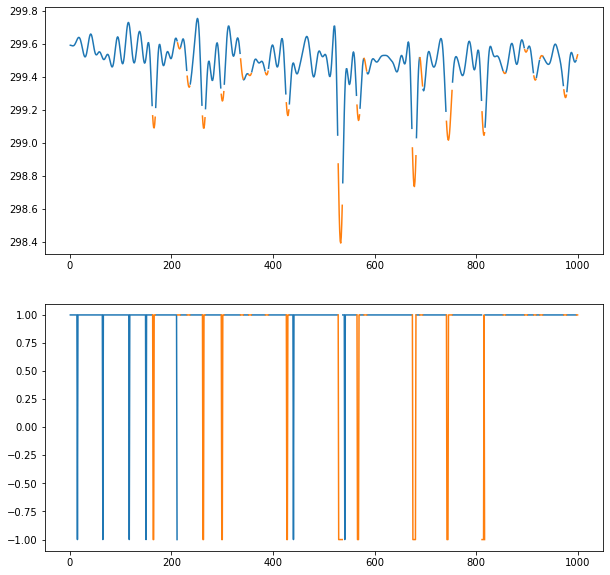

In [37]:
# Isolation Forest without smoothing

temp_pearson_cluster = ds_temp_r1['T2m'].values[:, pearson_npy_mask]

X = temp_pearson_cluster.copy()
X = StandardScaler().fit_transform(X)
clf = IsolationForest(random_state=0, contamination=0.04).fit(X)
outlier = clf.predict(X)

aod = ds_volc.AOD.values.flatten()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

mean_temp_pearson_cluster = np.mean(temp_pearson_cluster, axis=1)
plot_outlier(ax1, smooth_butter(mean_temp_pearson_cluster))
plot_outlier(ax2, outlier)

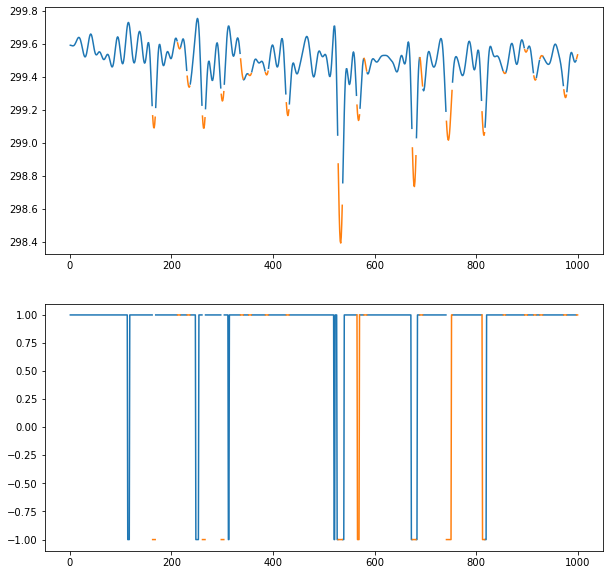

In [54]:
# Isolation Forest smoothed data:

temp_pearson_cluster = ds_temp_r1['T2m'].values[:, pearson_npy_mask]
smoothed_temp_pearson_cluster = np.zeros(temp_pearson_cluster.shape)
for i in np.arange(temp_pearson_cluster.shape[1]):
    smoothed_temp_pearson_cluster[:, i] = smooth_butter(temp_pearson_cluster[:, i])

X = smoothed_temp_pearson_cluster.copy()
X = StandardScaler().fit_transform(X)
clf = IsolationForest(random_state=0, contamination=0.08).fit(X)
outlier = clf.predict(X)

aod = ds_volc.AOD.values.flatten()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

mean_temp_pearson_cluster = np.mean(smoothed_temp_pearson_cluster, axis=1)
plot_outlier(ax1, mean_temp_pearson_cluster)
plot_outlier(ax2, outlier)

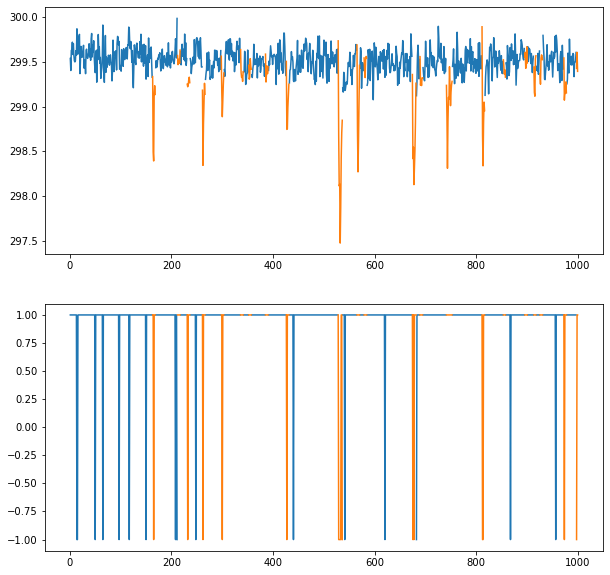

In [48]:
# one class SVM

temp_pearson_cluster = ds_temp_r1['T2m'].values[:, pearson_npy_mask]

X = temp_pearson_cluster.copy()
X = StandardScaler().fit_transform(X)
model = OneClassSVM(nu=0.03, kernel="rbf", gamma=0.01)
model.fit(X)
outlier = model.predict(X)

aod = ds_volc.AOD.values.flatten()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

mean_temp_pearson_cluster = np.mean(temp_pearson_cluster, axis=1)
plot_outlier(ax1, mean_temp_pearson_cluster)#smooth_butter(mean_temp_pearson_cluster))
plot_outlier(ax2, outlier)

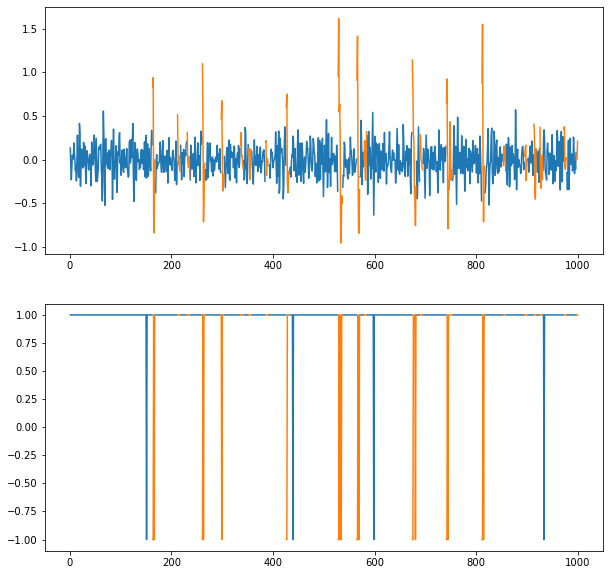

In [79]:
# Convolution (gradients)

temp_pearson_cluster_diff = np.zeros(temp_pearson_cluster.shape)
for i in range(temp_pearson_cluster.shape[1]):
    temp_pearson_cluster_diff[:, i] = ndimage.convolve(temp_pearson_cluster[:, i], [-1, 0, 1], mode='reflect')

X = temp_pearson_cluster_diff.copy()
X = StandardScaler().fit_transform(X)
clf = IsolationForest(random_state=0, contamination=0.03).fit(X)
outlier = clf.predict(X)

aod = ds_volc.AOD.values.flatten()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

mean_temp_pearson_cluster = np.mean(temp_pearson_cluster_diff, axis=1)
plot_outlier(ax1, mean_temp_pearson_cluster)
plot_outlier(ax2, outlier)